In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle

import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

### Data Acquisition

#### Create DataFrame

* Create dataframe with image_path, time(seconds) and speed

* In the video given, we have ~344 (5min 44s) seconds of video. 
* Our ground truth labels correspond to a video that is 12m 12s (~732seconds). 
* We only have a portion of that video. 
* It appears that our framerate <strong>~ 13 fps </strong>. (4459 frames * (1 second / 13frames) = 344 seconds)

In [2]:
df = pd.read_csv('./data/driving.csv')
df.head(10)
len(df)

4459

#### Plot Speeds vs Time

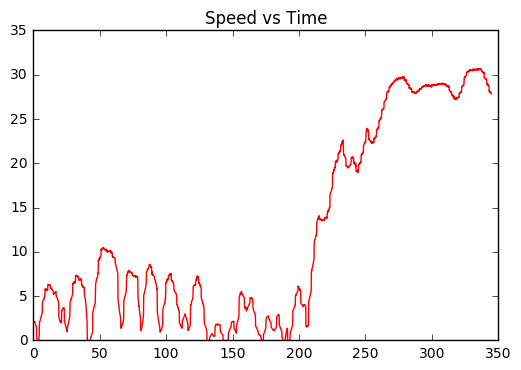

In [3]:
times = np.asarray(df['time'], dtype = np.float32)
speeds = np.asarray(df['speed'], dtype=np.float32)
plt.plot(times, speeds, 'r-')
plt.title('Speed vs Time')
plt.show()

In [4]:
df.tail(5)

,image_path,time,speed
4454,./data/IMG/344.3211498260498.jpg,344.321150,27.928958
4455,./data/IMG/344.37305998802185.jpg,344.373060,27.938640
4456,./data/IMG/344.5106108188629.jpg,344.510611,27.932405
4457,./data/IMG/344.5854048728943.jpg,344.585405,27.927574
4458,./data/IMG/344.63681387901306.jpg,344.636814,27.847842


### Shuffle Pairs and Train Test Split
* This function is a batch shuffler, 
* There is a 20% chance to add the row to validation data, other wise it will be train data

In [5]:
def batch_shuffle(dframe):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    for i in range(len(dframe) - 1):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data


In [6]:
train_data, valid_data = batch_shuffle(df)

In [7]:

print('valid_datA: ', len(valid_data))
print('train_data: ', len(train_data))

valid_datA:  1974
train_data:  6942


In [8]:
train_data.head(5)

,index,image_path,time,speed
0,4199,./data/IMG/322.343318939209.jpg,322.343319,28.149720
0,4200,./data/IMG/322.4041187763214.jpg,322.404119,28.443957
0,1969,./data/IMG/142.76181197166443.jpg,142.761812,0.606712
0,1970,./data/IMG/142.82951378822327.jpg,142.829514,0.000000
0,940,./data/IMG/67.88710689544678.jpg,67.887107,2.273210


## Preprocess

In [9]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

#### Perspective Transform

In [10]:
def apply_perspective_transform(image):
    pass

In [19]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             2) Perspective transform
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    image_cropped = image[100:440, :-90] # -> (380, 550, 3)
    # TODO: Write perspective transform 
#     perspective = apply_perspective_transform(image_cropped)
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

In [12]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

In [13]:
def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = change_brightness(img, bright_factor)

            
    img = preprocess_image(img)
    return img, speed

### Generators

#### Train Generator
* This is used to yield train batches of image_difference and average speed. 
* We pick a random spot in the training dataset, between 1 and length - 1
* determine the relationship between 3 frames
* locate the current_frame and the next_frame
* Take the difference between them and their average speed and build batches with that information
* Then shuffle the batch and yield it, which will then be fed into the network
* Generators allow me to not clog my memory stack so I can perform these operations on 16 (`BATCH` size) at a time

In [14]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['time'].values[0]
            time_prev = row_prev['time'].values[0]
            time_next = row_next['time'].values[0]
            
            if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58: # 0.578111 is highest diff i have seen
                # in this case row_prev is x1 and row_now is x2
                row1 = row_prev
                row2 = row_now
                
            elif time_next - time_now > 0 and 0.0000001 < time_next - time_now < 0.58:
                # in this case row_now is x1 and row_next is x2
                row1 = row_now
                row2 = row_next
            else:
                print('time_now is not next or prev: ', time_now)
                print('time_prev is :', time_prev)
                print('time_next is: ', time_next)
                
                print('\n diff: now  - prev \t', time_now - time_prev)
                print('\n diff: next - now: \t', time_next - time_now)
            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # subtract image features
            x = x1 - x2
            
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = x
            label_batch[i] = y
            
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

#### Validation Generator
* This is used to yield validation image_difference and average speed. 
* We pick iterate through the validation data, determine the relationship between 3 frames, locate the current_frame and the next_frame. Take the difference between them and their average speed and feed that into the network

In [15]:
def generate_validation_data(data):
    while True:
        for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['time'].values[0]
            time_prev = row_prev['time'].values[0]
            time_next = row_next['time'].values[0]
            
            if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58:
                # in this case row_prev is x1 and row_now is x2
                row1 = row_prev
                row2 = row_now
                
            elif time_next - time_now > 0 and 0.000001 < time_next - time_now < 0.58:
                # in this case row_now is x1 and row_next is x2
                row1 = row_now
                row2 = row_next
            
            
            
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
            
      
            
            
            
            img_diff = x1 - x2
            
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            yield img_diff, speed

### Nvidia Model

In [16]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
tf.python.control_flow_ops = tf

N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv1'))
    
    model.add(ELU())    
    model.add(Convolution2D(36, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 3, 3, 
                            subsample = (1,1), 
                            border_mode = 'valid',
                            init = 'he_normal', #gaussian init
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, 3, 3, 
                            subsample= (1,1), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, init = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, init = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, init = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', init = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

Using TensorFlow backend.


In [17]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)
BATCH = 16
print('val_size: ', val_size)

val_size:  1974


In [18]:
model = nvidia_model()
train_size = len(train_data.index)
for i in range(3):
    train_generator = generate_training_data(train_data, BATCH)
    history = model.fit_generator(
            train_generator, 
            samples_per_epoch = 20480, # try putting the whole thing in here in the future
            nb_epoch = 6,
            validation_data = valid_generator,
            nb_val_samples = val_size)
    print(history)
    
    model.save_weights('model-weights-F4.h5')
    model.save('model-F4.h5')

Epoch 1/6
20480/20480 [==============================] - 590s - loss: 111.3389 - val_loss: 93.9221
Epoch 2/6
20480/20480 [==============================] - 547s - loss: 78.0229 - val_loss: 66.2251
Epoch 3/6
20480/20480 [==============================] - 526s - loss: 50.1716 - val_loss: 54.8281
Epoch 4/6
20480/20480 [==============================] - 525s - loss: 32.6907 - val_loss: 42.4883
Epoch 5/6
20480/20480 [==============================] - 522s - loss: 22.4639 - val_loss: 36.4363
Epoch 6/6
20480/20480 [==============================] - 522s - loss: 16.4029 - val_loss: 33.9529
Epoch 1/6
20480/20480 [==============================] - 526s - loss: 12.3913 - val_loss: 28.4485
Epoch 2/6
20480/20480 [==============================] - 523s - loss: 9.4364 - val_loss: 28.5629
Epoch 3/6
20480/20480 [==============================] - 524s - loss: 8.0084 - val_loss: 27.8809
Epoch 4/6
20480/20480 [==============================] - 524s - loss: 6.6400 - val_loss: 26.2968
Epoch 5/6
20480/20480 

dict_keys(['val_loss', 'loss'])


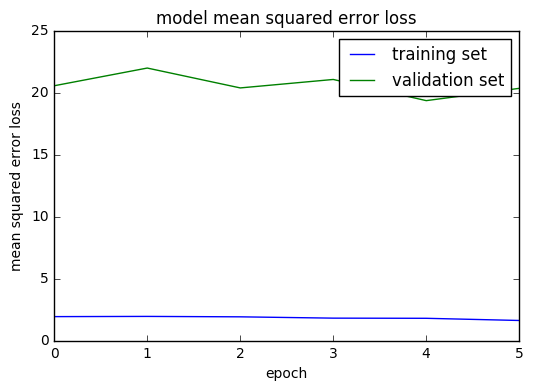

In [20]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Analysis
* With 6 epochs I noticed that I started to overfit my dataset when the validation loss started oscillating
* 5 loops 6 epochs: MSE (train):1.6149, MSE (valid): 20.3356
* 3 loops 6 epochs: MSE (train): , MSE (valid): 

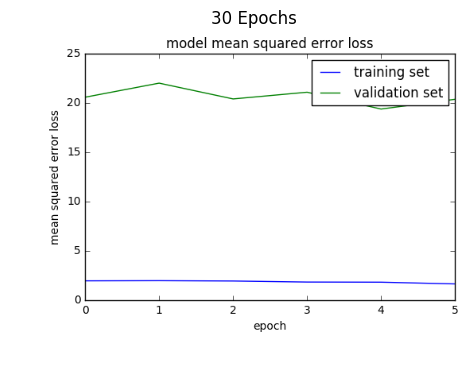

In [22]:
loop5epoch6 = mpimg.imread('./data/5Loops6EpochsDiag.png')
plt.imshow(loop5epoch6)
plt.axis('off')
plt.title('30 Epochs')

I probably overfit the dataset here, because my validation loss started to oscillate

In [ ]:
loop4Epoch6 = 

In [ ]:
# random selection
data = train_data
random_images = []
for i in range(20):
    idx = np.random.randint(len(data))
    row = data.iloc[[idx]].reset_index()
    x, y = preprocess_image_from_path(row['image_path'].values[0], row['speed'].values[0])
    random_images.append((x, y))
    
plt.figure(figsize=(16, 10))
gs1 = gridspec.GridSpec(4, 5)
gs1.update(wspace = 0.01, hspace = 0.01)
for idx, image in enumerate(random_images):
    angle = 'ang: ' + str(image[1]) 
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.title(angle)
    plt.imshow(image[0])
plt.show()

### IDEAS: 
* Run forwards (img1 - img2) mean(speed)
* Run backwards (img2 - img1) mean(speed)
* Compute speed differential then apply prediction as: current_speed += speed_difference
* speed_difference = xW + b

* Batch shuffler
* Apply perspective transform
* Sobely gradient 
* Gaussian blur

### Design considerations
* Originally I generated a new brightness factor for each image, but that created some disturbances when I wanted to take the difference between both images so instead I used the same brightness augmentation for the current_frame and the next_frame. It works both ways though, it may have been better to make a random brightness augmentation because at one instant if our frame is under clear lighting, and the next frame has a shadow, we would not know how to consider that pixel difference. 
* I used a generator and yielded batches of my results, I did this so I didn't clog my memory stack while training my model
* I took the input data and pushed the video images into a separate file and created a driving.csv file so I could use a pandas dataframe to read in each image path and only read in the image once I am in the generator. I could have just used moviepy and created a VideoFileClip and run all processing steps on each image, but I wouldn't have the same amount of control when testing out my preprocessing and data augmentation pipelines.